# Combining all results

In [66]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from pathlib import Path
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [67]:
colors_seg = ['#FFC107', '#1E88E5']

## Loading and merging data

In [68]:
df_fd_BOB = pd.read_csv('outputs/BOB_fd_results.csv')
df_fd_fs_seg = pd.read_csv('outputs/BOB_fd_results_freesurfer-seg.csv')
df_seg_metrics = pd.read_csv('outputs/segmentation_metrics.csv')
df_seg_volumnes = pd.read_csv('outputs/segmentation_volumes.csv')

In [69]:
df_seg_metrics_wb = pd.read_csv('outputs/whole_brain_csf_metrics.csv')
df_seg_metrics_all = pd.concat([df_seg_metrics, df_seg_metrics_wb], ignore_index=True, sort=False)
df_seg_metrics_all.head()

,participant_id,session_id,label,name,metric,value
0,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,Dice,0.742034
1,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,IoU,0.589868
2,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,Hausdorff,68.432448
3,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,HD95,2.828427
4,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,MI,0.054265


In [70]:
common_names = pd.Series(list(set(df_fd_BOB['name'].unique()) & set(df_fd_fs_seg['name'].unique())))
df_fd_BOB_common = df_fd_BOB[df_fd_BOB['name'].isin(common_names)]
df_fd_fs_seg_common = df_fd_fs_seg[df_fd_fs_seg['name'].isin(common_names)]

df_fd_BOB_common = df_fd_BOB_common.rename(columns={'fd': 'fd_BOB'})
df_fd_fs_seg_common = df_fd_fs_seg_common.rename(columns={'fd': 'fd_SynthSeg'})

df_fd_merged = pd.merge(
    df_fd_BOB_common[['participant_id', 'session_id', 'name', 'fd_BOB','age','sex']],
    df_fd_fs_seg_common[['participant_id', 'session_id', 'name', 'fd_SynthSeg']],
    on=['participant_id', 'session_id', 'name'],
    how='inner'
)
df_fd_merged.head()

,participant_id,session_id,name,fd_BOB,age,sex,fd_SynthSeg
0,sub-116056,ses-3mo,whole_brain,2.7598,3.6,Male,2.8088
1,sub-116056,ses-3mo,Left-Cerebral-White-Matter,2.4704,3.6,Male,2.4882
2,sub-116056,ses-3mo,Left-Cerebral-Cortex,2.4475,3.6,Male,2.4989
3,sub-116056,ses-3mo,Left-Lateral-Ventricle,1.5052,3.6,Male,1.4089
4,sub-116056,ses-3mo,Left-Inf-Lat-Vent,1.3861,3.6,Male,1.1902


In [71]:
df_fd_wb = pd.read_csv('outputs/fd_wb_minus_csf.csv')
# Extract age and sex
meta = (
    df_fd_merged[["participant_id","session_id","age","sex"]]
    .drop_duplicates()  # one row per unique (participant_id,session_id)
)

# Left‐join
df_fd_wb_enriched = df_fd_wb.merge(
    meta,
    on=["participant_id","session_id"],
    how="left"
)

df_fd_wb_enriched.drop(columns=['label', 'min_box_size','max_box_size'], inplace=True)
df_fd_wb_enriched.head()

,participant_id,session_id,name,fd_BOB,fd_SynthSeg,age,sex
0,sub-116056,ses-3mo,whole_brain_minus_CSF,2.7598,2.7760,3.6,Male
1,sub-116845,ses-3mo,whole_brain_minus_CSF,2.7585,2.7689,3.6,Female
2,sub-116845,ses-6mo,whole_brain_minus_CSF,2.7724,2.7784,6.5,Female
3,sub-176427,ses-5mo,whole_brain_minus_CSF,2.7594,2.7709,5.0,Female
4,sub-198202,ses-5mo,whole_brain_minus_CSF,2.7735,2.7850,5.9,Male


In [72]:
df_fd_all = pd.concat([df_fd_merged, df_fd_wb_enriched], ignore_index=True, sort=False)
df_fd_all.head()

,participant_id,session_id,name,fd_BOB,age,sex,fd_SynthSeg
0,sub-116056,ses-3mo,whole_brain,2.7598,3.6,Male,2.8088
1,sub-116056,ses-3mo,Left-Cerebral-White-Matter,2.4704,3.6,Male,2.4882
2,sub-116056,ses-3mo,Left-Cerebral-Cortex,2.4475,3.6,Male,2.4989
3,sub-116056,ses-3mo,Left-Lateral-Ventricle,1.5052,3.6,Male,1.4089
4,sub-116056,ses-3mo,Left-Inf-Lat-Vent,1.3861,3.6,Male,1.1902


In [73]:
df_seg_volumnes_wide = df_seg_volumnes.pivot_table(
    index=['participant_id', 'session_id', 'name'],
    columns='metric',
    values='value'
).reset_index()
df_seg_volumnes_wide.head()

metric,participant_id,session_id,name,volume_BOB,volume_SynthSeg,volume_diff,volume_diff_abs,volume_norm_percent_diff,volume_ratio
0,sub-116056,ses-3mo,3rd-Ventricle,897.0,700.0,197.0,197.0,24.671259,1.281429
1,sub-116056,ses-3mo,4th-Ventricle,603.0,527.0,76.0,76.0,13.451327,1.144213
2,sub-116056,ses-3mo,Brain-Stem,11435.0,11614.0,-179.0,179.0,1.553213,0.984588
3,sub-116056,ses-3mo,Left-Accumbens-area,330.0,433.0,-103.0,103.0,26.998689,0.762125
4,sub-116056,ses-3mo,Left-Amygdala,708.0,1091.0,-383.0,383.0,42.579211,0.648946


In [74]:
df_seg_metrics_wide = df_seg_metrics_all.pivot_table(
    index=['participant_id', 'session_id', 'name'],
    columns='metric',
    values='value'
).reset_index()
df_seg_metrics_wide.head()

metric,participant_id,session_id,name,Dice,HD95,Hausdorff,IoU,MI,NMI
0,sub-116056,ses-3mo,3rd-Ventricle,0.771446,1.414214,6.403124,0.627931,0.000772,0.690873
1,sub-116056,ses-3mo,4th-Ventricle,0.736283,2.790519,11.445523,0.582633,0.000531,0.648855
2,sub-116056,ses-3mo,Brain-Stem,0.835524,3.162278,13.000000,0.717511,0.008734,0.735596
3,sub-116056,ses-3mo,Left-Accumbens-area,0.351245,3.000000,3.605551,0.213037,0.000153,0.266767
4,sub-116056,ses-3mo,Left-Amygdala,0.718177,2.094419,3.605551,0.560278,0.000792,0.637966


In [75]:
df_fd_all['fd_diff'] = df_fd_all['fd_BOB'] - df_fd_all['fd_SynthSeg']
df_fd_all['fd_diff_abs'] = df_fd_all['fd_diff'].abs()

In [76]:
df_fd_volume = pd.merge(
    df_fd_all,
    df_seg_volumnes_wide,
    on=['participant_id', 'session_id','name'],
    how='inner'
)
df_fd_volume.head()

,participant_id,session_id,name,fd_BOB,age,sex,fd_SynthSeg,fd_diff,fd_diff_abs,volume_BOB,volume_SynthSeg,volume_diff,volume_diff_abs,volume_norm_percent_diff,volume_ratio
0,sub-116056,ses-3mo,whole_brain,2.7598,3.6,Male,2.8088,-0.0490,0.0490,713007.0,928871.0,-215864.0,215864.0,26.294767,0.767606
1,sub-116056,ses-3mo,Left-Cerebral-White-Matter,2.4704,3.6,Male,2.4882,-0.0178,0.0178,147515.0,140019.0,7496.0,7496.0,5.213992,1.053536
2,sub-116056,ses-3mo,Left-Cerebral-Cortex,2.4475,3.6,Male,2.4989,-0.0514,0.0514,146600.0,181855.0,-35255.0,35255.0,21.467172,0.806137
3,sub-116056,ses-3mo,Left-Lateral-Ventricle,1.5052,3.6,Male,1.4089,0.0963,0.0963,4487.0,3046.0,1441.0,1441.0,38.258330,1.473079
4,sub-116056,ses-3mo,Left-Inf-Lat-Vent,1.3861,3.6,Male,1.1902,0.1959,0.1959,351.0,258.0,93.0,93.0,30.541872,1.360465


In [77]:
df_fd_volume_metrics = pd.merge(
    df_fd_volume,
    df_seg_metrics_wide,
    on=['participant_id', 'session_id','name'],
    how='inner'
)
df_fd_volume_metrics.head()

,participant_id,session_id,name,fd_BOB,age,sex,fd_SynthSeg,fd_diff,fd_diff_abs,volume_BOB,...,volume_diff,volume_diff_abs,volume_norm_percent_diff,volume_ratio,Dice,HD95,Hausdorff,IoU,MI,NMI
0,sub-116056,ses-3mo,whole_brain,2.7598,3.6,Male,2.8088,-0.0490,0.0490,713007.0,...,-215864.0,215864.0,26.294767,0.767606,0.868057,20.099751,58.864251,0.766874,0.251933,0.713601
1,sub-116056,ses-3mo,Left-Cerebral-White-Matter,2.4704,3.6,Male,2.4882,-0.0178,0.0178,147515.0,...,7496.0,7496.0,5.213992,1.053536,0.742034,2.828427,68.432448,0.589868,0.054265,0.555543
2,sub-116056,ses-3mo,Left-Cerebral-Cortex,2.4475,3.6,Male,2.4989,-0.0514,0.0514,146600.0,...,-35255.0,35255.0,21.467172,0.806137,0.703688,2.000000,7.071068,0.542839,0.055091,0.508236
3,sub-116056,ses-3mo,Left-Lateral-Ventricle,1.5052,3.6,Male,1.4089,0.0963,0.0963,4487.0,...,1441.0,1441.0,38.258330,1.473079,0.677818,3.506543,19.235384,0.512651,0.002552,0.572870
4,sub-116056,ses-3mo,Left-Inf-Lat-Vent,1.3861,3.6,Male,1.1902,0.1959,0.1959,351.0,...,93.0,93.0,30.541872,1.360465,0.397373,2.828427,33.301652,0.247951,0.000145,0.310883


## Volume

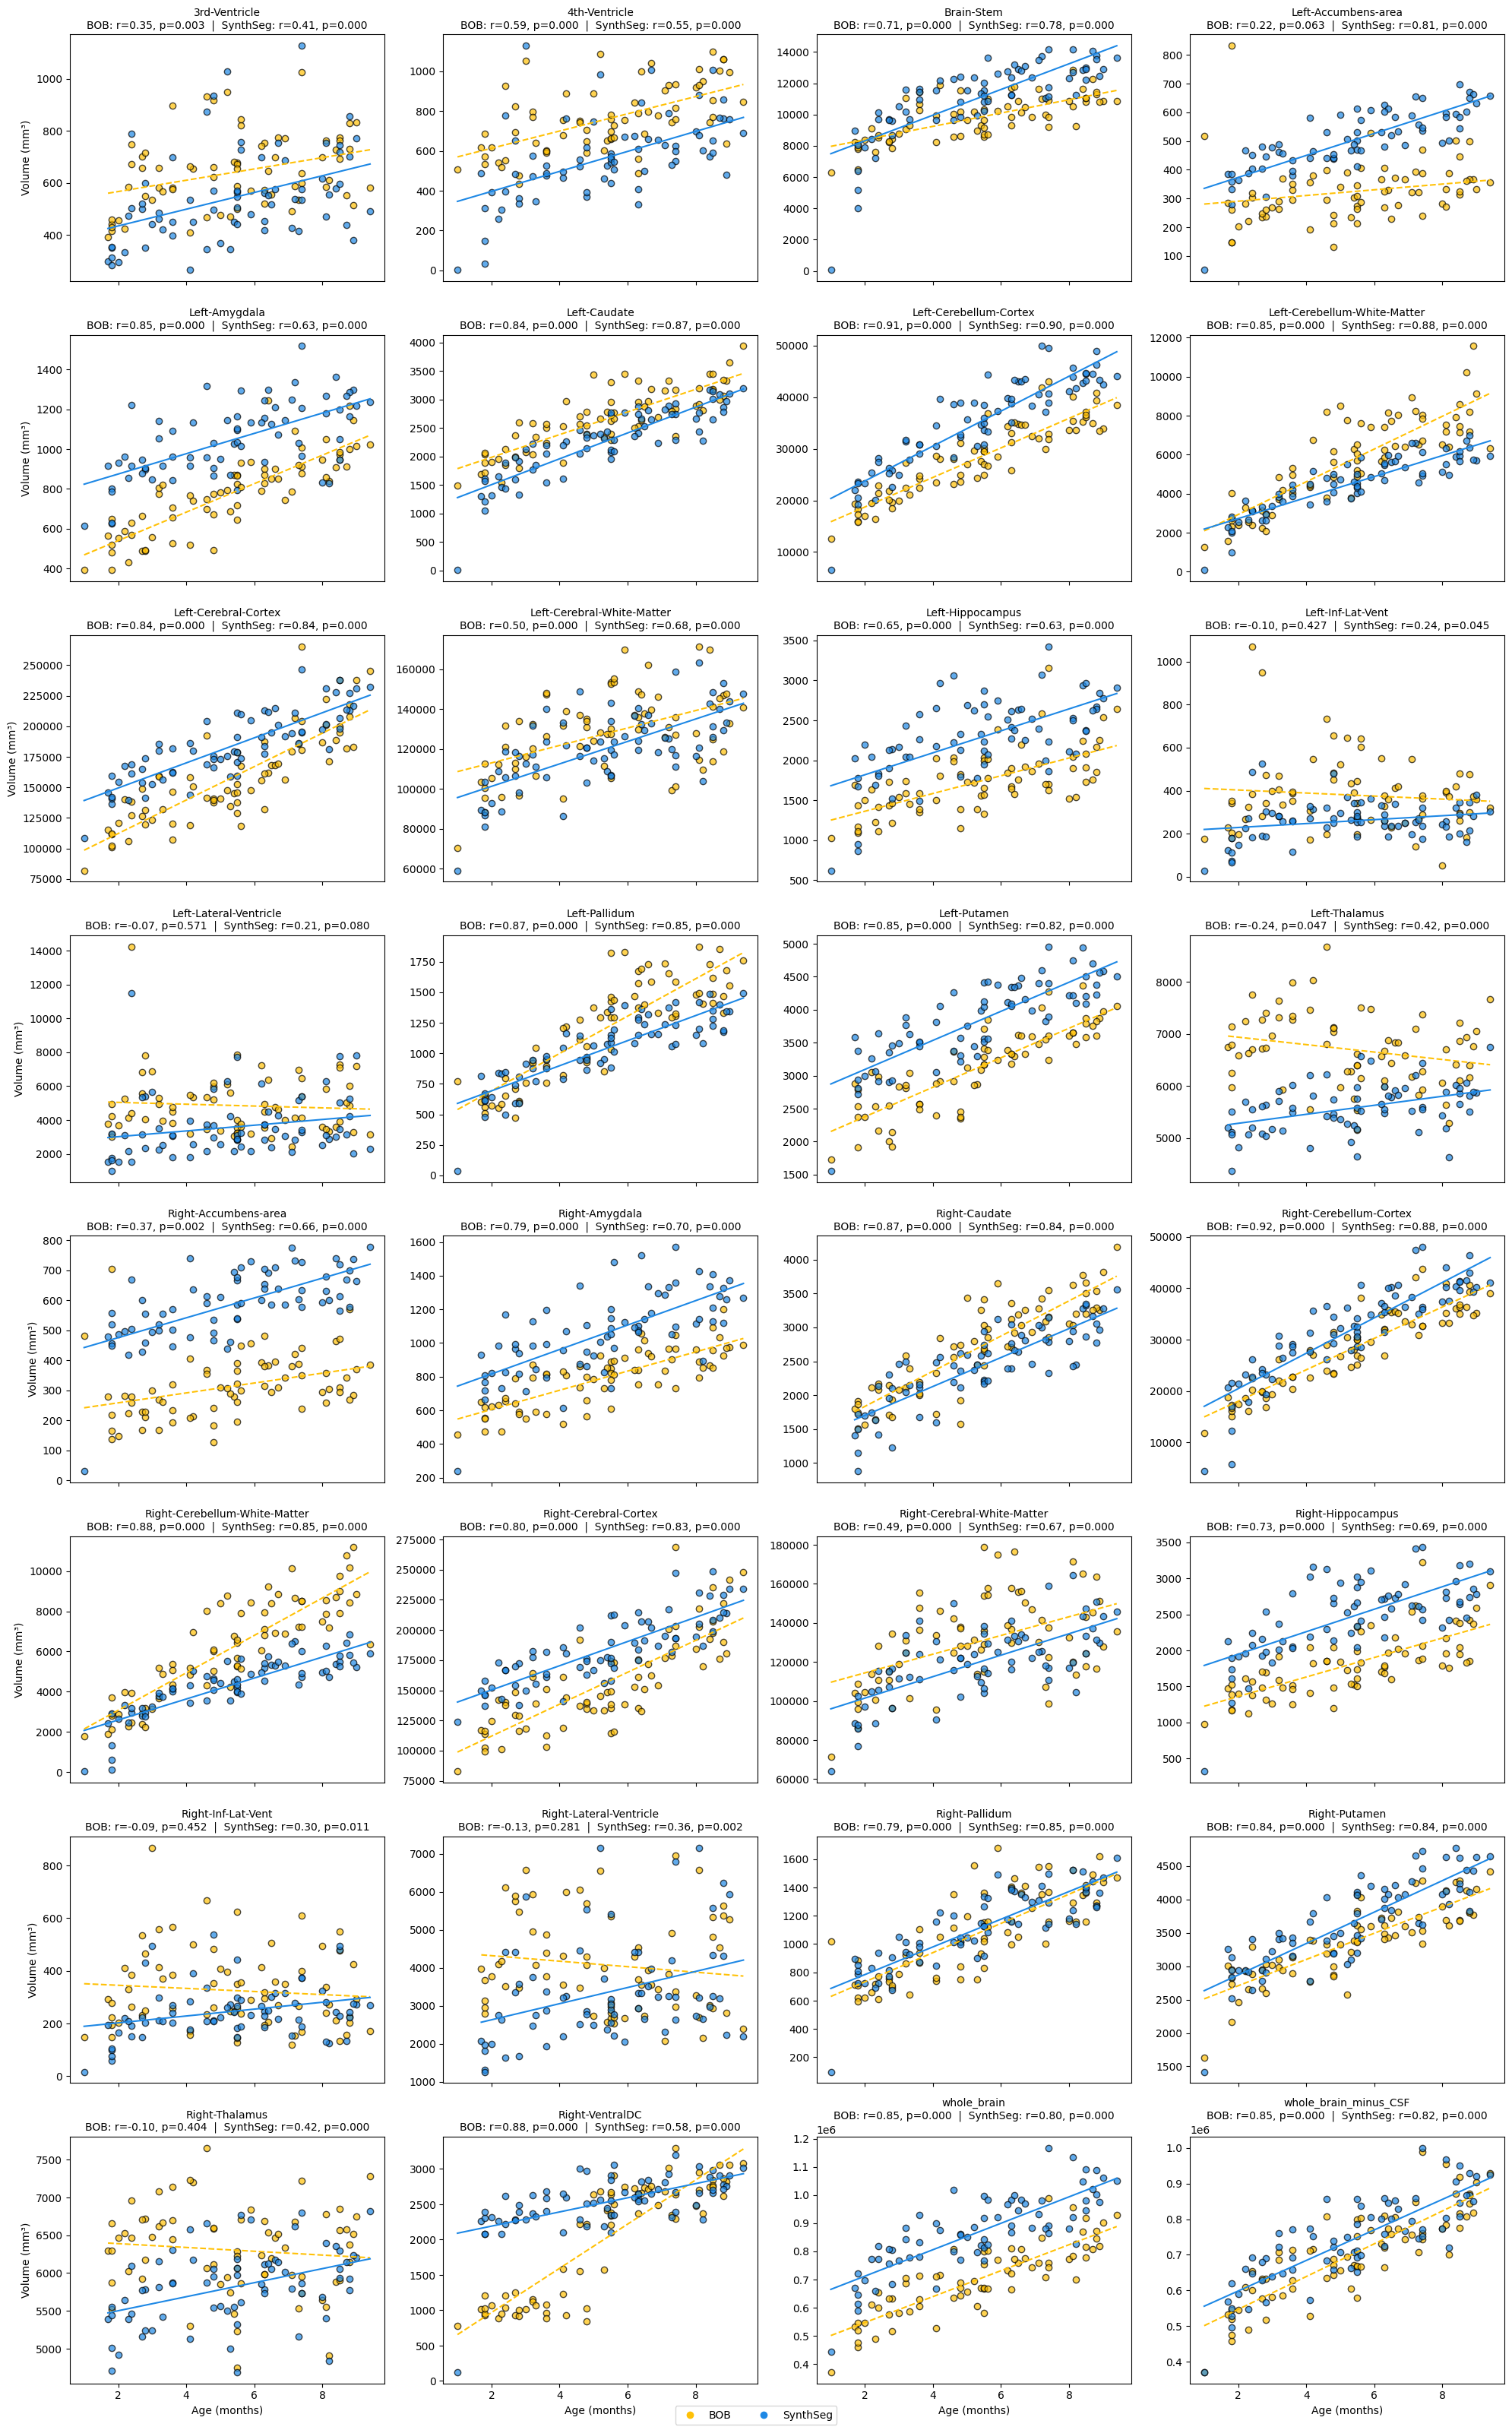

In [83]:
base_list = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']
base_list.sort()


n = len(base_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 5, nrows * 4),
    sharex=True
)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    
    # Subset for this structure
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == base]
    ages = sub['age'].values
    
    # Grab volume columns instead of FD
    vols_BOB      = sub['volume_BOB'].values
    vols_SynthSeg = sub['volume_SynthSeg'].values
    
    # Scatter plot for each method
    ax.scatter(
        ages, vols_BOB,
        label='BOB',
        color=colors_seg[0],
        edgecolor='k',
        alpha=0.7
    )
    ax.scatter(
        ages, vols_SynthSeg,
        label='SynthSeg',
        color=colors_seg[1],
        edgecolor='k',
        alpha=0.7
    )
    
    # Fit regression line for BOB
    if len(ages) > 1:
        slope_bob, intercept_bob = np.polyfit(ages, vols_BOB, 1)
        x_line = np.linspace(ages.min(), ages.max(), 100)
        y_line_bob = slope_bob * x_line + intercept_bob
        ax.plot(
            x_line, y_line_bob,
            color=colors_seg[0], linestyle='--'
        )

    # Fit regression line for SynthSeg
    if len(ages) > 1:
        slope_ss, intercept_ss = np.polyfit(ages, vols_SynthSeg, 1)
        y_line_ss = slope_ss * x_line + intercept_ss
        ax.plot(
            x_line, y_line_ss,
            color=colors_seg[1], linestyle='-'
        )
    
    # Pearson correlations
    if len(ages) > 1:
        r_bob, p_bob = pearsonr(ages, vols_BOB)
        r_ss,  p_ss  = pearsonr(ages, vols_SynthSeg)
    else:
        r_bob = p_bob = r_ss = p_ss = np.nan

    ax.set_title(
        f"{base}\n"
        f"BOB: r={r_bob:.2f}, p={p_bob:.3f}  |  "
        f"SynthSeg: r={r_ss:.2f}, p={p_ss:.3f}",
        fontsize=10
    )
    
    # Only label x‐axis on the bottom row
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    # Only label y‐axis on the left column
    if idx % ncols == 0:
        ax.set_ylabel("Volume (mm³)")

# Turn off any unused axes
for j in range(n, len(axes)):
    axes[j].axis('off')

# Single legend at bottom
handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               color=colors_seg[0], label='BOB'),
    plt.Line2D([], [], marker='o', linestyle='None',
               color=colors_seg[1], label='SynthSeg')
]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()


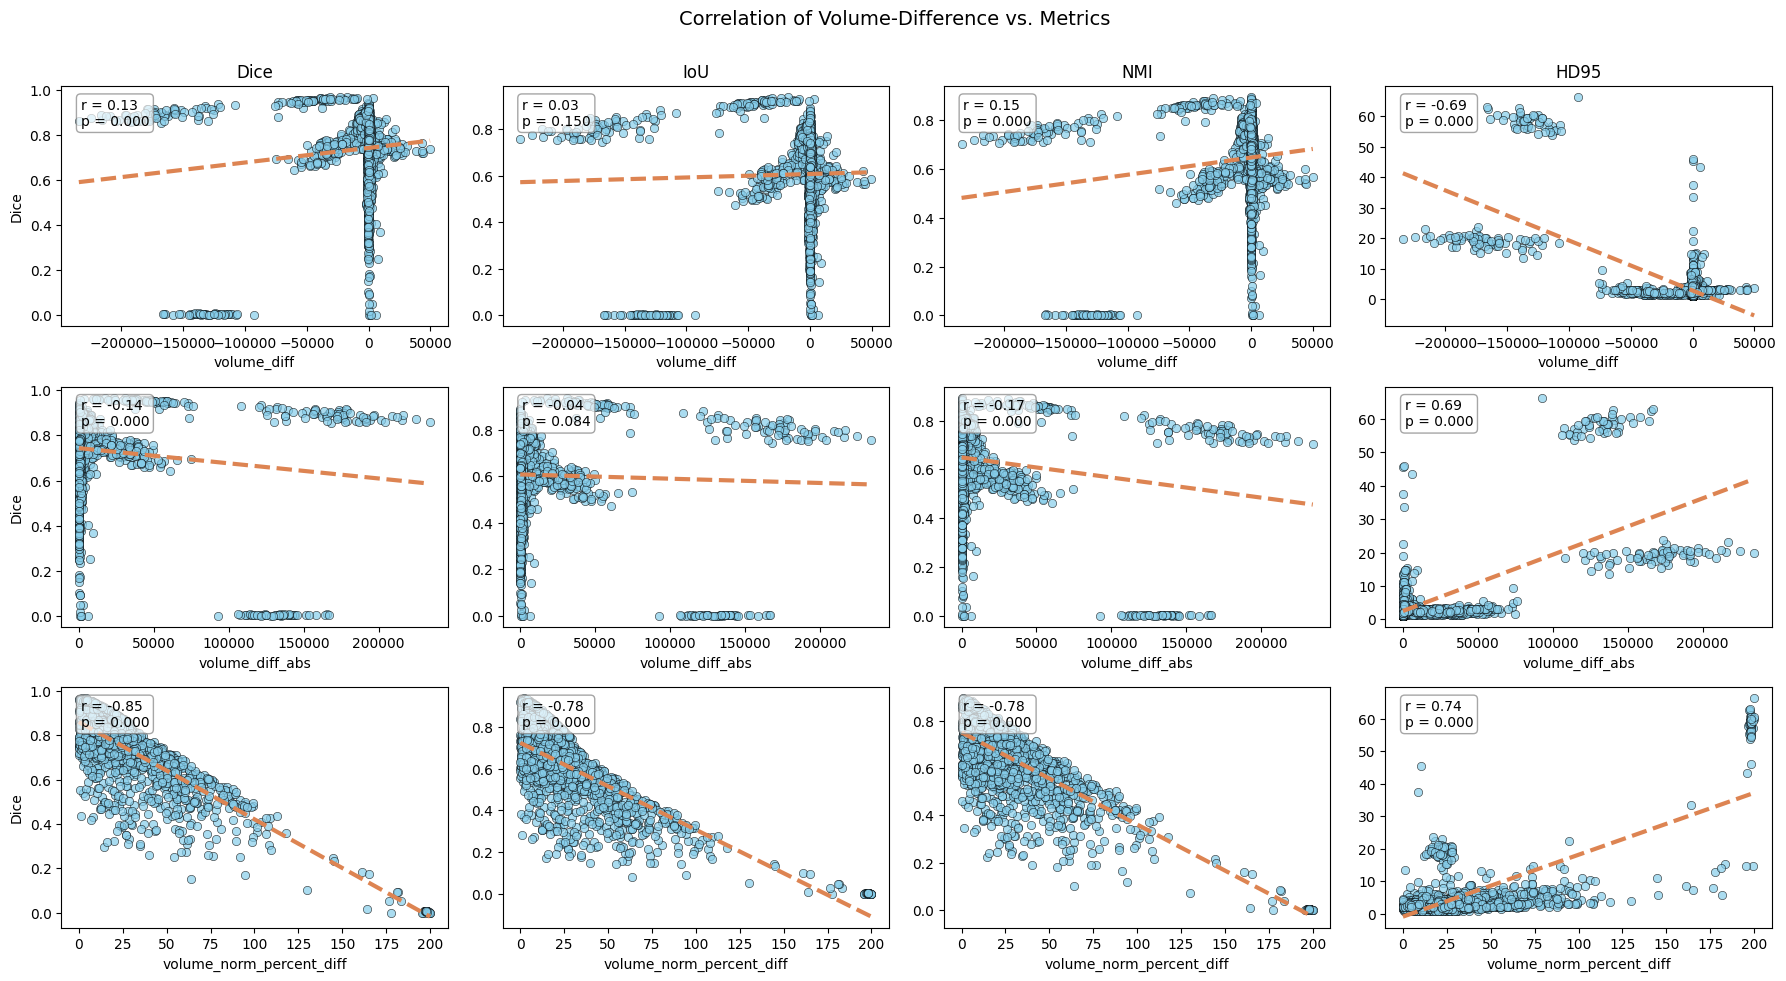

In [100]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_cols  = ["volume_diff", "volume_diff_abs", "volume_norm_percent_diff"]

nrows = len(x_cols)   # 3
ncols = len(metrics)  # 4

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 4.5, nrows * 3.5),
    sharex=False
)

# Flatten axes for easy indexing if needed, but we'll also use a 2D index:
axes = np.array(axes)

for i, x_col in enumerate(x_cols):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # Filter out NaNs
        sub = df_fd_volume_metrics.dropna(subset=[x_col, metric])
        x = sub[x_col].values
        y = sub[metric].values
        
        # Scatter plot
        sns.scatterplot(x=x, y=y, ax=ax, color='skyblue', edgecolor='k', alpha=0.7)

        
        # Fit regression line if ≥ 2 points
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color="#dd8452", linestyle="--",lw=3)
        
        # Pearson correlation
        if len(x) > 1:
            r, p = pearsonr(x, y)
        else:
            r, p = np.nan, np.nan
        
        # Annotate r and p in top-left
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor="gray",
                alpha=0.7
            )
        )
        
        # Only set titles on the top row
        if i == 0:
            ax.set_title(metric, fontsize=12)
        
        # Only label y‐axis on the first column
        if j == 0:
            ax.set_ylabel(metric, fontsize=10)
        else:
            ax.set_ylabel("")
        

        ax.set_xlabel(x_col, fontsize=10)

# Tight layout and super‐title
fig.suptitle("Correlation of Volume‐Difference vs. Metrics", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.975])
plt.show()


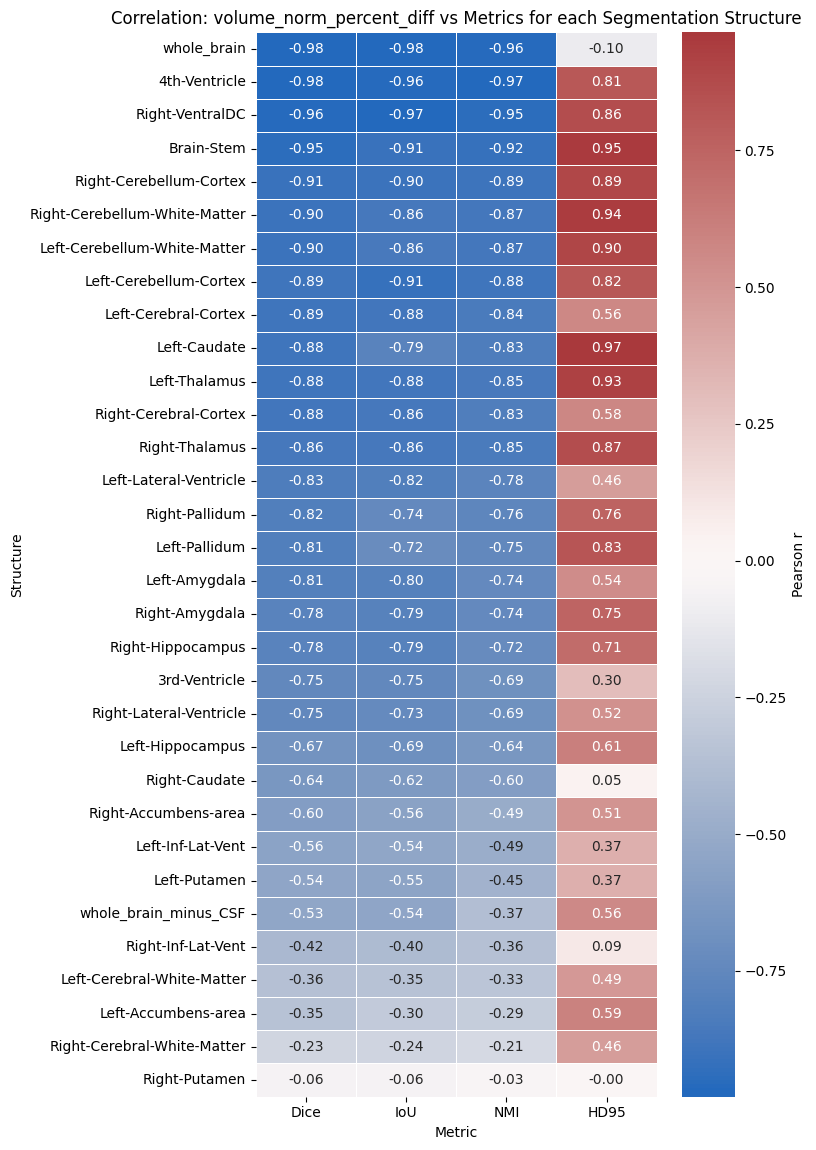

In [ ]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_col = "volume_norm_percent_diff"

structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

corr_df = pd.DataFrame(index=structures, columns=metrics, dtype=float)

# fill in corr_df for each structure & each metric, compute Pearson r
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    for metric in metrics:
        # Drop NaNs
        valid = sub[[x_col, metric]].dropna()
        if len(valid) > 1:
            r, _ = pearsonr(valid[x_col], valid[metric])
        else:
            r = np.nan
        corr_df.at[struct, metric] = r

corr_df = corr_df.sort_values(by="Dice", ascending=True)

# plot a heatmap of the correlation coefficients
plt.figure(figsize=(8, len(structures) * 0.3 + 2))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="vlag",     # diverging palette centered at 0
    center=0,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5
)
plt.title(f"Correlation: {x_col} vs Metrics for each Segmentation Structure")
plt.xlabel("Metric")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()


## Fractal dimension

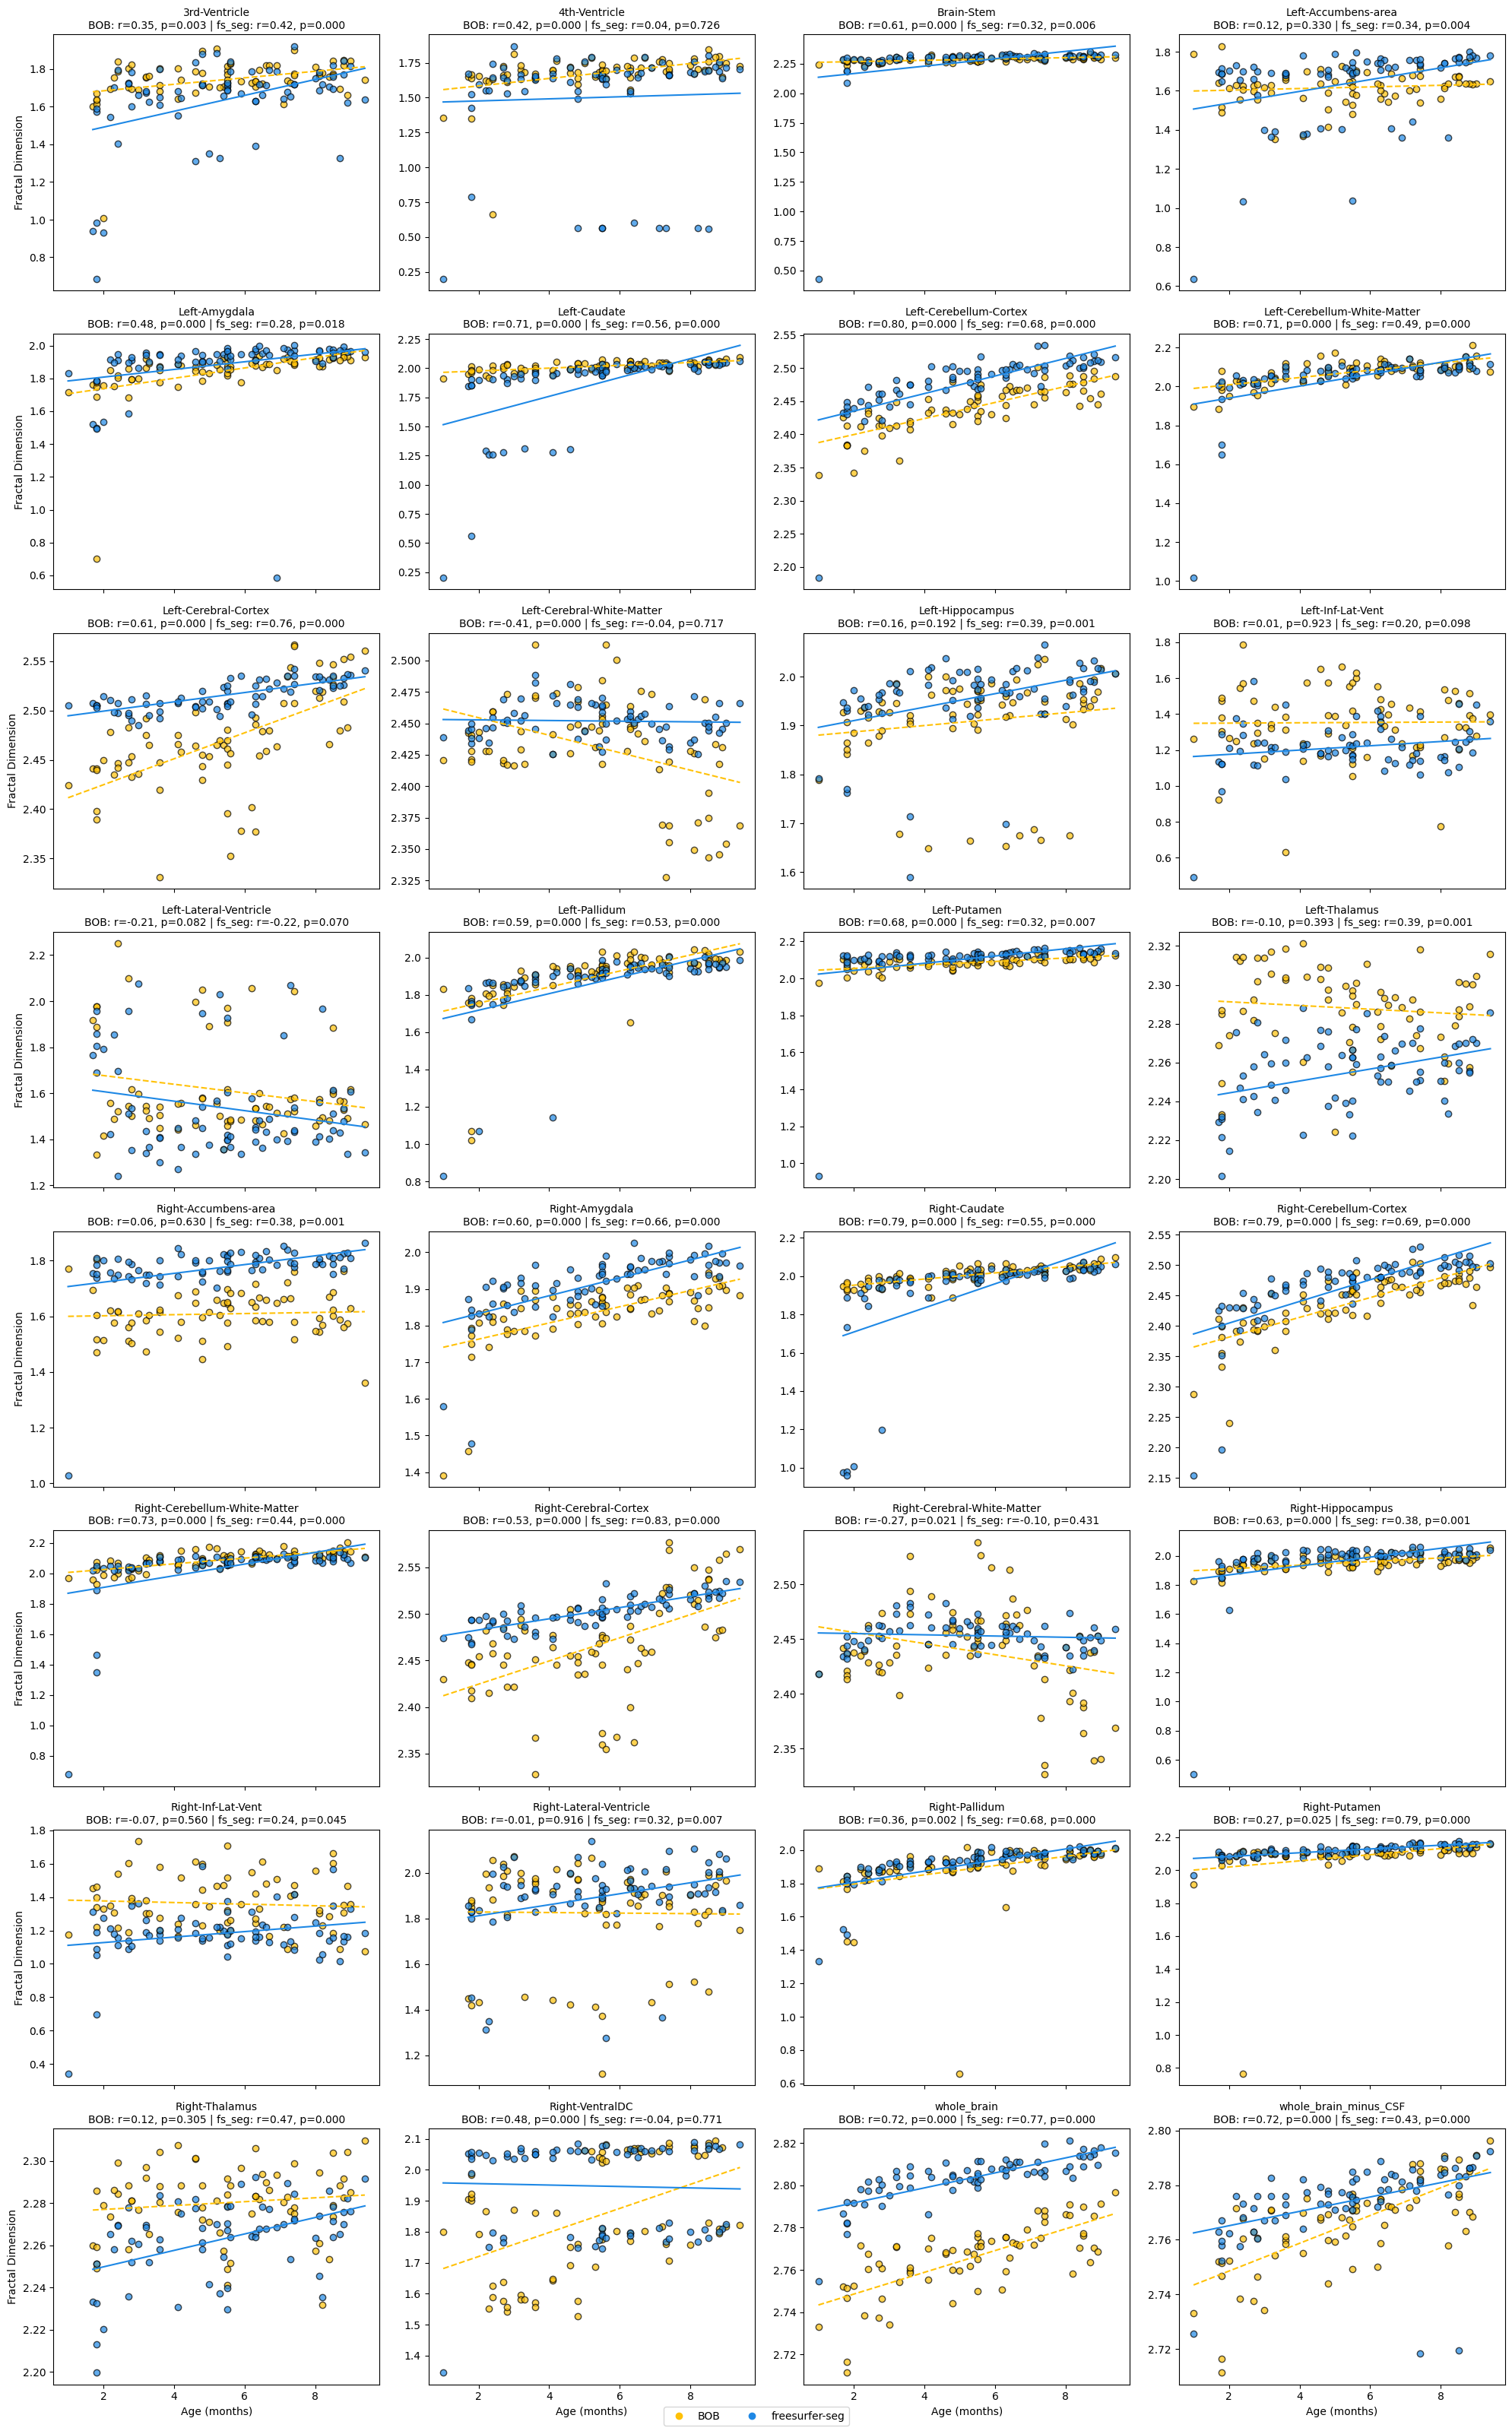

In [84]:
base_list = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']
base_list.sort()

n = len(base_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols * 5, nrows * 4),
                         sharex=True)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == base]
    ages = sub['age'].values
    
    fds_BOB = sub['fd_BOB'].values
    fds_fs_seg = sub['fd_SynthSeg'].values
    
    # Scatter plot for each method
    ax.scatter(ages, fds_BOB, label='BOB', color=colors_seg[0], edgecolor='k', alpha=0.7)
    ax.scatter(ages, fds_fs_seg, label='SynthSeg', color=colors_seg[1], edgecolor='k', alpha=0.7)
    
    # Fit regression line for BOB
    if len(ages) > 1:
        slope_bob, intercept_bob = np.polyfit(ages, fds_BOB, 1)
        x_line = np.linspace(ages.min(), ages.max(), 100)
        y_line_bob = slope_bob * x_line + intercept_bob
        ax.plot(x_line, y_line_bob, color=colors_seg[0], linestyle='--')

    # Fit regression line for fs_seg
    if len(ages) > 1:
        slope_fs, intercept_fs = np.polyfit(ages, fds_fs_seg, 1)
        y_line_fs = slope_fs * x_line + intercept_fs
        ax.plot(x_line, y_line_fs, color=colors_seg[1], linestyle='-')
    
    # Pearson correlations
    r_bob, p_bob = pearsonr(ages, fds_BOB)
    r_fs, p_fs = pearsonr(ages, fds_fs_seg)

    ax.set_title(f"{base}\nBOB: r={r_bob:.2f}, p={p_bob:.3f} | fs_seg: r={r_fs:.2f}, p={p_fs:.3f}", fontsize=10)
    
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    if idx % ncols == 0:
        ax.set_ylabel("Fractal Dimension")

# Turn off unused axes
for j in range(n, len(axes)):
    axes[j].axis('off')

# Add legend once
handles = [plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[0], label='BOB'),
           plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[1], label='freesurfer-seg')]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()


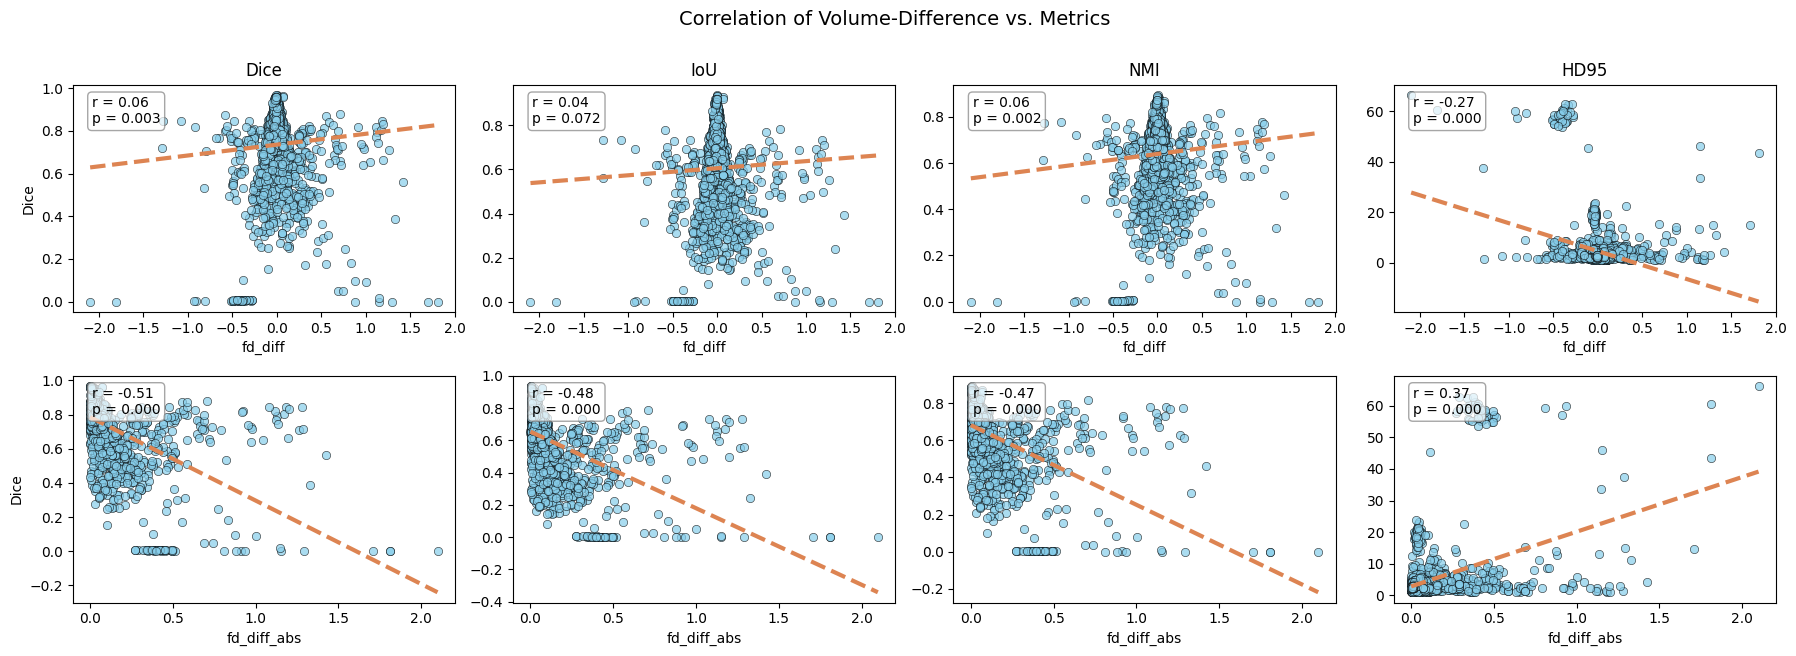

In [101]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_cols  = ["fd_diff", "fd_diff_abs"]

nrows = len(x_cols)   
ncols = len(metrics) 

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 4.5, nrows * 3.5),
    sharex=False
)

# Flatten axes for easy indexing if needed, but we'll also use a 2D index:
axes = np.array(axes)

for i, x_col in enumerate(x_cols):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # Filter out NaNs
        sub = df_fd_volume_metrics.dropna(subset=[x_col, metric])
        x = sub[x_col].values
        y = sub[metric].values
        
        # Scatter plot
        sns.scatterplot(x=x, y=y, ax=ax, color='skyblue', edgecolor='k', alpha=0.7)

        
        # Fit regression line if ≥ 2 points
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color="#dd8452", linestyle="--",lw=3)
        
        # Pearson correlation
        if len(x) > 1:
            r, p = pearsonr(x, y)
        else:
            r, p = np.nan, np.nan
        
        # Annotate r and p in top-left
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor="gray",
                alpha=0.7
            )
        )
        
        # Only set titles on the top row
        if i == 0:
            ax.set_title(metric, fontsize=12)
        
        # Only label y‐axis on the first column
        if j == 0:
            ax.set_ylabel(metric, fontsize=10)
        else:
            ax.set_ylabel("")
        

        ax.set_xlabel(x_col, fontsize=10)

# Tight layout and super‐title
fig.suptitle("Correlation of Volume‐Difference vs. Metrics", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.975])
plt.show()


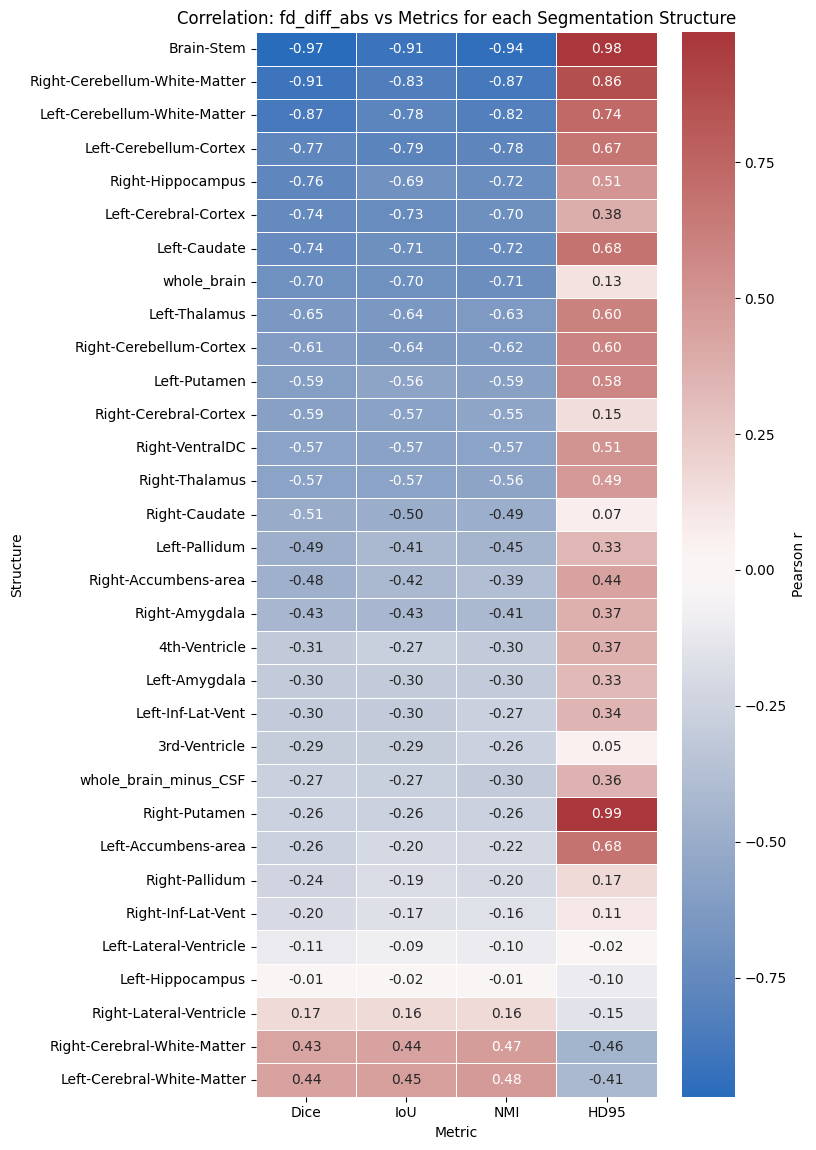

In [107]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_col = "fd_diff_abs"

structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

corr_df = pd.DataFrame(index=structures, columns=metrics, dtype=float)

# fill in corr_df for each structure & each metric, compute Pearson r
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    for metric in metrics:
        # Drop NaNs
        valid = sub[[x_col, metric]].dropna()
        if len(valid) > 1:
            r, _ = pearsonr(valid[x_col], valid[metric])
        else:
            r = np.nan
        corr_df.at[struct, metric] = r

corr_df = corr_df.sort_values(by="Dice", ascending=True)

# plot a heatmap of the correlation coefficients
plt.figure(figsize=(8, len(structures) * 0.3 + 2))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="vlag",     # diverging palette centered at 0
    center=0,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5
)
plt.title(f"Correlation: {x_col} vs Metrics for each Segmentation Structure")
plt.xlabel("Metric")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()

### Volume diff and FD diff correlation

C:\Users\natha\AppData\Local\Temp\ipykernel_29300\1120478000.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


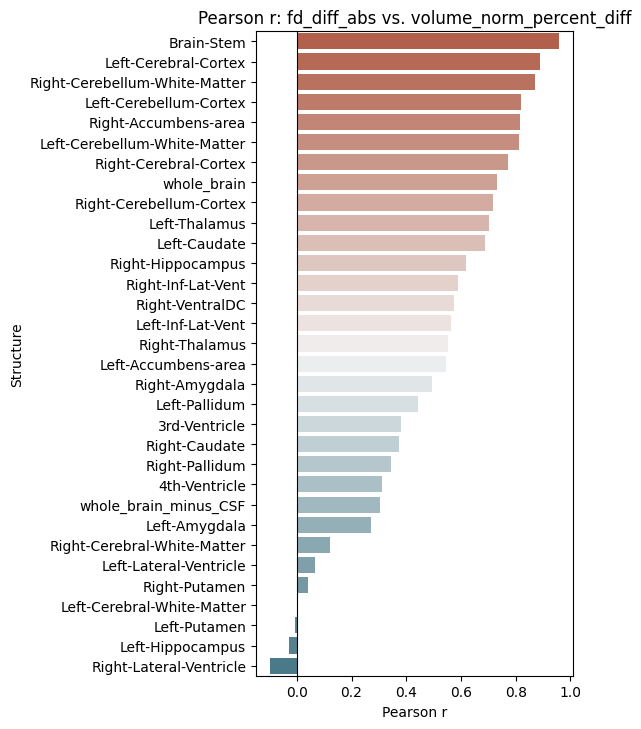

In [ ]:
structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

# for each structure, compute Pearson r between fd_diff_abs and volume_norm_percent_diff
corr_list = []
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    sub = sub.dropna(subset=["fd_diff_abs", "volume_norm_percent_diff"])
    if len(sub) > 1:
        r, p = pearsonr(sub["volume_norm_percent_diff"], sub["fd_diff_abs"])
    else:
        r, p = np.nan, np.nan
    corr_list.append({"name": struct, "r": r, "p": p})

corr_df = pd.DataFrame(corr_list).set_index("name").sort_values("r", ascending=False)
palette = sns.diverging_palette(20, 220, n=len(df_plot), as_cmap=False)

# barplot of correlation coefficients
plt.figure(figsize=(6, len(corr_df) * 0.2 + 1))
sns.barplot(
    x="r",
    y=corr_df.index,
    data=corr_df.reset_index(),
    palette=palette,
)
plt.axvline(0, color="k", linewidth=0.8)
plt.title("Pearson r: fd_diff_abs vs. volume_norm_percent_diff")
plt.xlabel("Pearson r")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()